<p style='font-family: times, serif; font-size:25pt; font-style:bold; color:black;'>
    BlueMath - SHyTCWaves
</p>

<p style='font-family: times, serif; font-size:16pt; font-style:bold; color:black;'>
    Non-stationary SWAN: <u>historical</u> TC into 6h-segments
</p>

<hr size="5"/>

<span style='font-family: times, arial; font-size:14pt; font-weight:bold; color:black;'> Table of Contents </span>

* [1. Load data (from preprocessing nb)](#1.-Load-data-(from-preprocessing-nb))


* [2. SWAN project](#2.-SWAN-project)
    * [2.1 SWAN main mesh](#2.1-SWAN-main-mesh)
    * [2.2 SWAN nested mesh](#2.2-SWAN-nested-mesh)
    * [2.3 SWAN case parameters](#2.3-SWAN-case-parameters)
    * [2.4 SWAN input: storm track, no waves](#2.4-SWAN-input:-storm-track,-no-waves)


* [3. Plot site configuration](#3.-Plot-site-configuration)


* [4. SWAN WRAP](#4.-SWAN-WRAP)
    * [4.1 Build cases](#4.1-Build-cases)
        * [Plot input: Vortex winds](#Plot-input:-Vortex-winds)
        * [Plot input: Graffiti maximum winds](#Plot-input:-Graffiti-maximum-winds)
    * [4.2 Run cases](#4.2-Run-cases)
        * [Plot output: Hsig](#Plot-output:-Hsig)
        * [Plot output: Graffiti maximum Hsig](#Plot-output:-Graffiti-maximum-Hsig)
        * [Plot output: Control Point time series](#Plot-output:-Control-Point-time-series)
    * [4.3 Extract output](#4.3-Extract-output)

<br>

<div class="alert alert-block alert-warning">
    
<b>Info:</b> this notebook imports SWAN input data (from preprocessing nb), defines SWAN configuration and meshes, builds and runs SWAN case. </div>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from hywaves.swan.storms import historic_track_preprocessing, historic_track_interpolation
from hywaves.swan.stopmotion import storm2stopmotion, stopmotion_interpolation

# plotting
from hywaves.swan.plots.nonstationary import plot_project_site, plot_case_input, \
plot_case_output_grafiti, plot_case_vortex_grafiti, plot_case_output_points, \
plot_case_vortex_input, plot_case_output, plot_matrix_input, plot_matrix_grafiti
from hywaves.swan.plots.stopmotion import plot_grid_segments, plot_segments_orientation


##  **1. Database**

In [2]:
# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', '..', 'data'))
p_demo = op.join(p_data, 'demo', 'samoa')

# load storm
storm = xr.open_dataset(op.join(p_demo, 'storm_ibtracs_OFA_Samoa.nc'))

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_demo, 'depth_Samoa.nc'))


##  **2. SWAN project**

In [3]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_04_demo'                 # project name

sp = SwanProject(p_proj, n_proj)


###  **2.1. SWAN main mesh**

In [4]:
# NOTE: cartesian coordinates convention

# computational grid description
res = 15*10**3   # km to m
xlength, ylength = 1500*10**3, 1500*10**3    # km to m

# create domain centered at (x,y)=(0,0)
lon = np.arange(-xlength/2, xlength/2, res)
lat = np.arange(-ylength/2, ylength/2, res)

# create uniform bathymetry (deep waters, -1000m)
depth = 1000 * np.ones((lon.size, lat.size))


# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value
main_mesh.depth = depth

# computational grid description
# res = 0.136  # (15km = 0.136º)  

main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),
}

sp.set_main_mesh(main_mesh)

###  **2.2. SWAN case parameters**

In [5]:
input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',   # angle convention for wind/waves
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'CARTESIAN',     # 'SPHERICAL',
    'coords_projection': '',        # 'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '20 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '20 MIN',
    'output_deltt': '1 HR',         # MUST BE MULTIPLE OF 'compute_deltc'
    
    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],
    
    'numerics':[
        'PROP BSBT',
    ],

    'output_variables': ['HSIGN', 'WIND', 'PTHSIGN','PTRTP','PTWLEN','PTDIR','PTDSPR'],
    
    'output_points_x': [50000, 100000, 150000, 200000, 250000, 300000], 
    'output_points_y': [50000, 100000, 150000, 200000, 250000, 300000],

    'output_points_spec': True,
    
    #'output_spec': True,  # Block output spectra: SPECOUT 'COMPGRID' SPEC2D ABS 'output_spec.nc' OUT 19900203.0400 20 MIN
    #'output_spec_deltt': '1 HR',
    
    #'output_time_ini_specout': 24,
    #'output_time_ini_block': 12,
    #'output_time_ini_table': 6,
    
}
sp.set_params(input_params)


###  **2.3. SWAN input: storm track, no waves**

In [6]:
# target coordinates
target = 'Samoa'
x0, y0 = -172.8, -13.5

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]


#####  **Storm data preprocessing**
Given a historical storm track, a function processes the data and returns arrays without NaNs, and with time format.


In [7]:
# preprocess storm variables (Ibtracs v4)
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
    'maxwinds': 'wmo_wind',
    'rmw': None,
}

st_time, ylat_tc, ylon_tc, ycpres, ywind, ts, categ, vmean = historic_track_preprocessing(storm, d_vns)


#####  **Storm segmentation**
Storm track coordinates are interpolated at a predefined time interval (6-hour segments).


In [8]:
# STOPMOTION, 6h intervals/segments
dt_interp = 60*6       # minutes

# generate interpolated storm track  
st, time_input = historic_track_interpolation(
    st_time, ylon_tc, ylat_tc, ycpres, ywind,
    y0, x0, lat[0], lon[0], lat[-1], lon[-1],  
    ts, dt_interp, wind=ywind,
    great_circle=True, interpolation=False, mode='mean',    # NO INTERPOLATION
)

st   # move(º) vf(kt) p0(mbar) vmax(kt)


,move,vf,vfx,vfy,pn,p0,lon,lat,vmax
1990-01-30 00:00:00,223.197158,2.946963,2.017229,2.148344,1013,996.0,180.122223,-8.033334,32.5
1990-01-30 06:00:00,223.197158,2.946963,2.017229,2.148344,1013,996.0,180.327654,-7.815098,32.5
1990-01-30 12:00:00,281.364626,3.340136,3.274646,-0.658181,1013,992.5,180.533325,-7.600000,37.5
1990-01-30 18:00:00,281.364626,3.340136,3.274646,-0.658181,1013,992.5,180.866694,-7.666717,37.5
1990-01-31 00:00:00,305.438242,3.415284,2.782571,-1.980267,1013,988.5,181.199997,-7.733334,42.5
1990-01-31 06:00:00,305.438242,3.415284,2.782571,-1.980267,1013,988.5,181.483450,-7.934355,42.5
1990-01-31 12:00:00,308.925927,4.204170,3.270671,-2.641544,1013,986.0,181.766663,-8.133333,47.5
1990-01-31 18:00:00,296.790453,4.393199,3.921637,-1.980142,1013,985.0,182.100021,-8.400001,50.0
1990-02-01 00:00:00,291.993138,5.284296,4.899751,-1.978945,1013,982.5,182.500000,-8.599999,52.5
1990-02-01 06:00:00,309.606105,4.661086,3.591112,-2.971471,1013,980.0,183.000000,-8.800000,55.0


#####  **Stop-motion parameterization**
Each storm 6-hour target segment is parameterized in terms of 10 parameters (P,dP,V,dV,W,dW,R,dR,lat,dAng), or stopmotion units.<br>
This generates independent segment events from consecutive track segments.


In [9]:
# load pmin-vmax polynomial fitting coefficients
xds_coef = xr.open_dataset(op.join(p_demo, 'ibtracs_coef_basins_centers.nc'))

# generate stopmotion segments (warmup+target variables)
d_vns_df = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'p0',
    'maxwinds': 'vmax',
    'rmw': None,
}

df_seg = storm2stopmotion(st, d_vns_df, xds_coef, var=['pressure','wind'], varfill=['rmw'])
df_seg[:10]


,time,longitude,latitude,pressure,wind,rmw,pseg,wseg,lseg,laseg,...,aseg,dpseg,dwseg,dlseg,dlaseg,drseg,dvseg,dvxseg,dvyseg,daseg
time,,,,,,,,,,,,,,,,,,,,,
1990-01-30 00:00:00,1990-01-30 00:00:00,180.122223,-8.033334,996.0,32.5,43.225866,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30 06:00:00,1990-01-30 06:00:00,180.327654,-7.815098,996.0,32.5,43.149458,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30 12:00:00,1990-01-30 12:00:00,180.533325,-7.600000,992.5,37.5,39.551719,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30 18:00:00,1990-01-30 18:00:00,180.866694,-7.666717,992.5,37.5,39.574226,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31 00:00:00,1990-01-31 00:00:00,181.199997,-7.733334,988.5,42.5,36.359009,990.50,40.00,-7.700025,7.700025,...,101.425103,-2.00,2.50,-0.133819,0.133819,-1.572817,1.263657,0.261149,-5.125665,-51.238213
1990-01-31 06:00:00,1990-01-31 06:00:00,181.483450,-7.934355,988.5,42.5,36.428593,988.50,42.50,-7.833844,7.833844,...,125.616831,-1.25,2.50,-0.200000,0.200000,-1.414088,1.040472,-0.106934,-3.144105,-29.351357
1990-01-31 12:00:00,1990-01-31 12:00:00,181.766663,-8.133333,986.0,47.5,33.530833,987.25,45.00,-8.033844,8.033844,...,125.377011,-1.75,3.75,-0.232823,0.232823,-2.094423,1.687044,0.452274,-2.479651,-15.307186
1990-01-31 18:00:00,1990-01-31 18:00:00,182.100021,-8.400001,985.0,50.0,32.239747,985.50,48.75,-8.266667,8.266667,...,128.973858,-1.75,2.50,-0.233333,0.233333,-1.271717,1.617004,1.671739,-0.314285,4.218139
1990-02-01 00:00:00,1990-02-01 00:00:00,182.500000,-8.599999,982.5,52.5,30.987399,983.75,51.25,-8.500000,8.500000,...,116.849574,-2.50,2.50,-0.200000,0.200000,-1.222060,2.696122,3.197140,0.305481,11.982224


#####  **List of stop-motion parameterized events**
A list is generated with independent stop-motion events (24h+6h+42h = 3 days).


In [10]:
# st_list units: x(m), y(m), vf(kt), p0(mbar), vmax(kt), rmw(nmile), lat(º)
st_list, we_list = stopmotion_interpolation(df_seg, st)


In [11]:
# for demonstration: only solve 4 stopmotion cases
#st_list = st_list[0:4]
#we_list = we_list[0:4]
#df_seg = df_seg


In [12]:
# computational time step [min] following Vmean criteria: 
# if vmean < 20km/h  dt_comp=20' 
# if vmean > 20km/h  dt_comp=10' 

for i in range(len(st_list)):
    st_vmean = np.nanmean(st_list[i].vf.values)
    
    if st_vmean*1.852 < 20:      dt_comp = 20
    elif st_vmean*1.852 >= 20:   dt_comp = 10
 
    # override SWAN storm case computational delta time
    st_list[i].attrs['override_dtcomp'] = '{0} MIN'.format(dt_comp) 
    
    # TODO: fix lon,lat - x,y duplication
    #st_list[i]['lon'] = st_list[i]['x']
    #st_list[i]['lat'] = st_list[i]['y']

    st_list[i].x0 = 0
    st_list[i].y0 = 0
    

**Plot storm vs stopmotion segments**


In [13]:
#plot_grid_segments(st_list, df_seg, st, xlength, ylength, width=33, height=27);


In [14]:
#plot_segments_orientation(st_list, df_seg, st, xlength, ylength, N=5, batch=0);


##  **3. Plot site configuration**

In [15]:
# plot site depth, control points, nested meshes (if any)
#plot_project_site(sp, vmin=-6000, vmax=40);


##  **4. SWAN WRAP**

In [16]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)


###  **4.1 Build cases**

In [17]:
# TODO: hablar con Sara de "rmw". No funciona correctamente
#st_list = [st.drop('rmw', axis=1) for st in st_list]


In [18]:
# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases(we_list, storm_track_list=st_list, make_waves=False, make_levels=False)


CASE 0000 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0001 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0002 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0003 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0004 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0005 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0006 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0007 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0008 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0009 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0010 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0011 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0012 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0013 - compute_deltc, wind_deltin

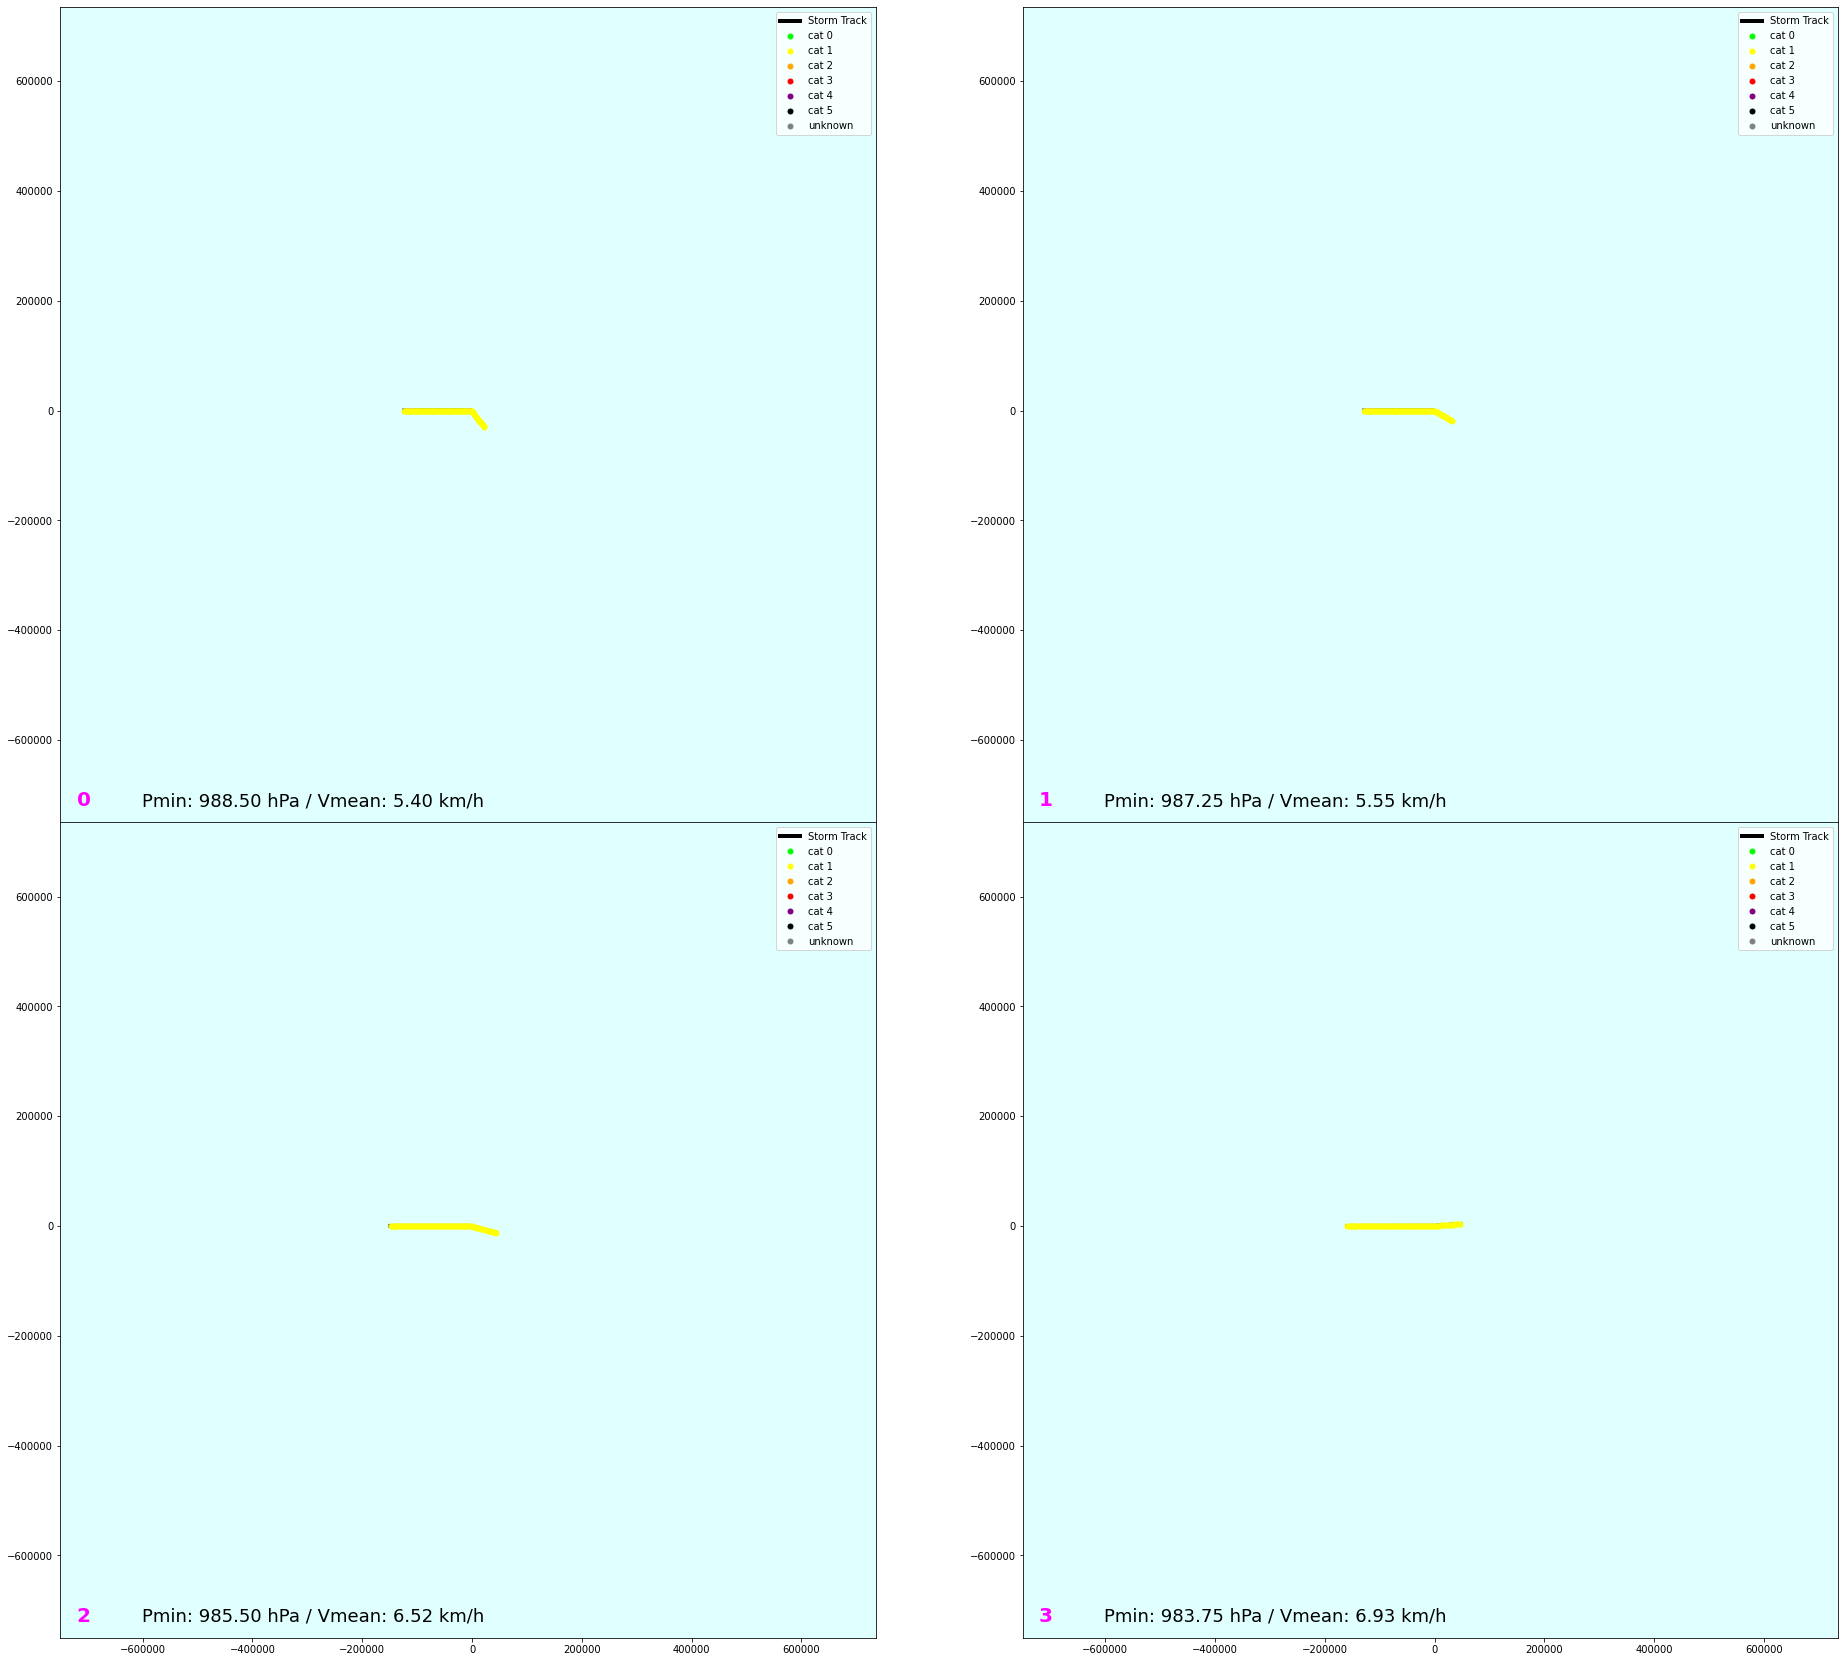

In [19]:
plot_matrix_input(sp, storm_track_list=st_list, case_ini=0, case_end=4);


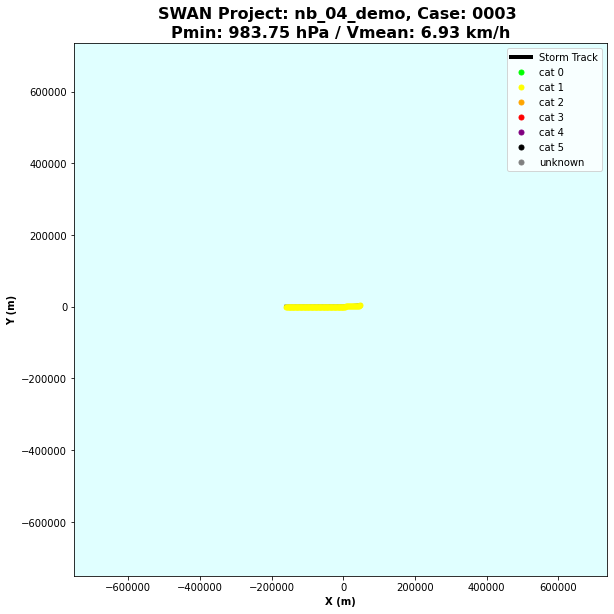

In [20]:
plot_case_input(sp, storm_track_list = st_list, case_number=3);


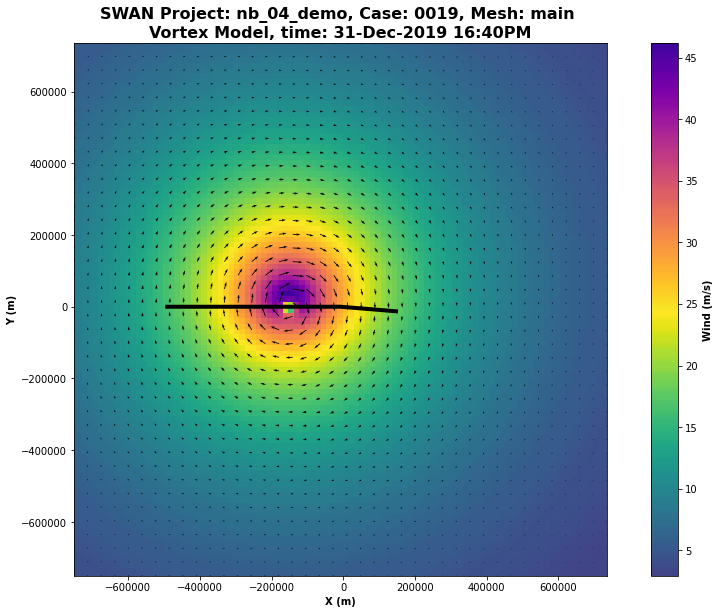

In [21]:
plot_case_vortex_input(sw, storm_track_list = st_list, case_number=19, t_num=50);


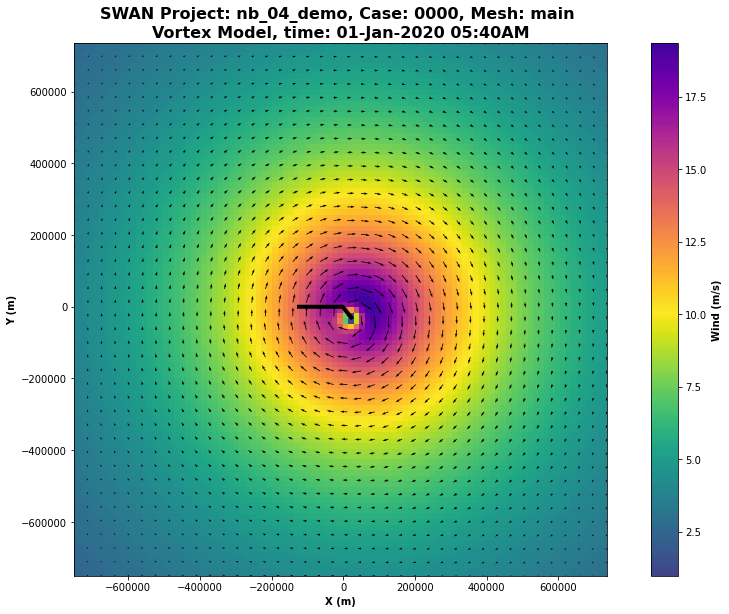

In [22]:
fig = plot_case_vortex_input(sw, storm_track_list = st_list, case_number=0, t_num=89);


#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot input: Graffiti maximum winds

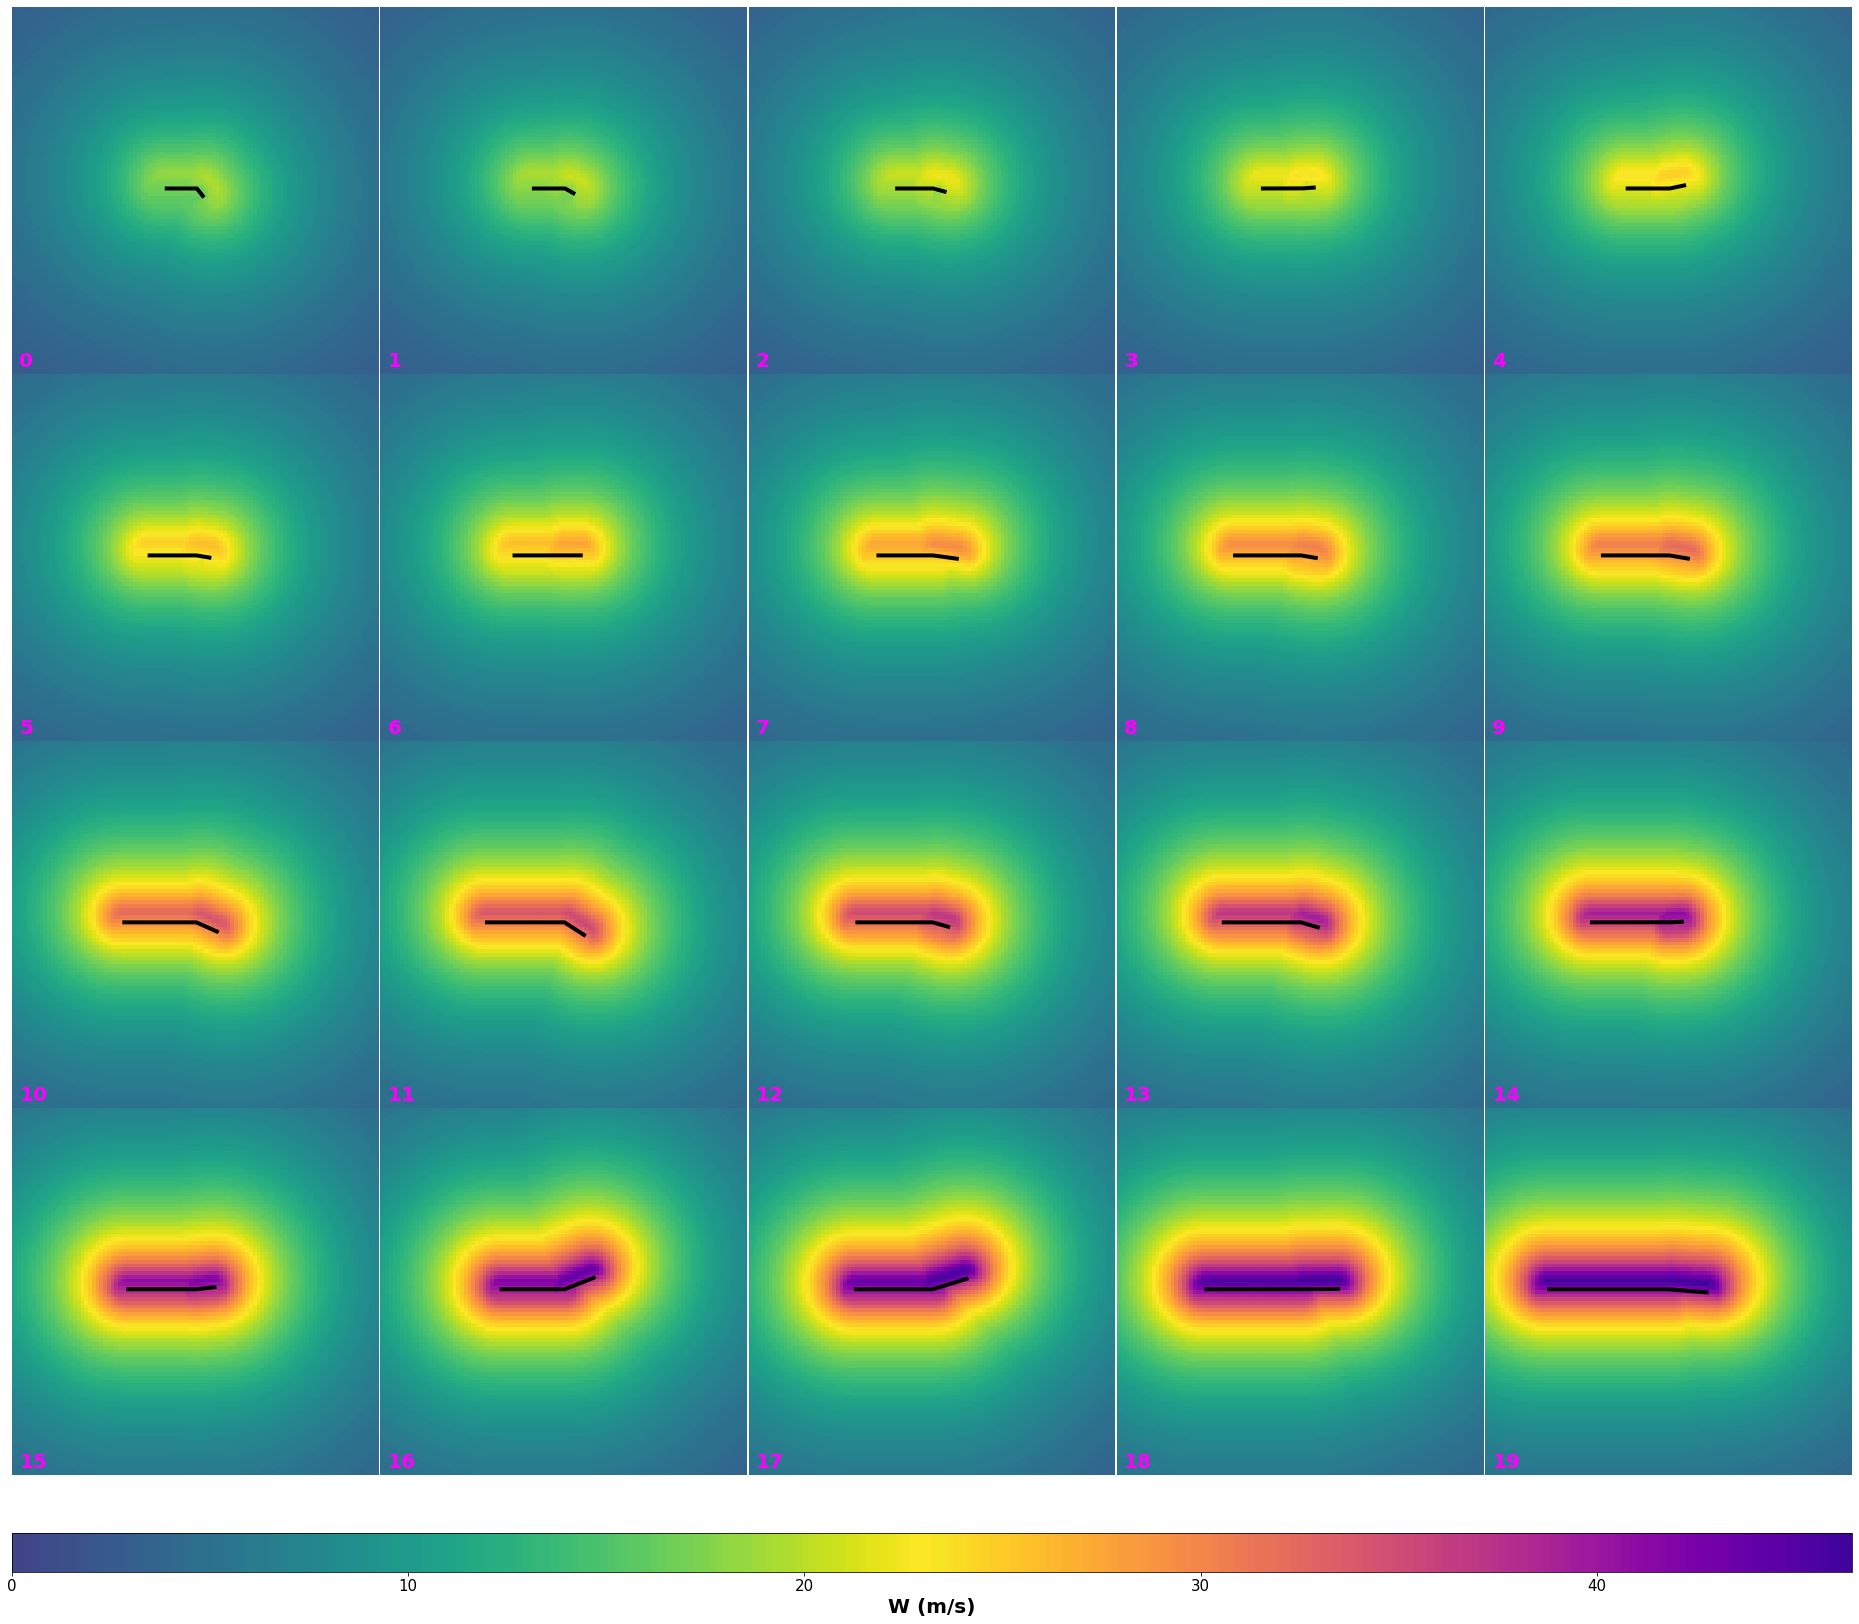

In [23]:
#plot_matrix_grafiti(sw, 'W', storm_track_list=st_list, case_ini=0, case_end=4, width=33, height=27);
plot_matrix_grafiti(sw, 'W', storm_track_list=st_list, case_ini=0, case_end=20, width=33, height=27);


#####  **4.2 Run cases**

In [24]:
sw.run_cases()


SWAN CASE: 0000 SOLVED
SWAN CASE: 0001 SOLVED
SWAN CASE: 0002 SOLVED
SWAN CASE: 0003 SOLVED
SWAN CASE: 0004 SOLVED
SWAN CASE: 0005 SOLVED
SWAN CASE: 0006 SOLVED
SWAN CASE: 0007 SOLVED
SWAN CASE: 0008 SOLVED
SWAN CASE: 0009 SOLVED
SWAN CASE: 0010 SOLVED
SWAN CASE: 0011 SOLVED
SWAN CASE: 0012 SOLVED
SWAN CASE: 0013 SOLVED
SWAN CASE: 0014 SOLVED
SWAN CASE: 0015 SOLVED
SWAN CASE: 0016 SOLVED
SWAN CASE: 0017 SOLVED
SWAN CASE: 0018 SOLVED
SWAN CASE: 0019 SOLVED


#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Hsig

In [25]:
# fig = plot_case_output(sw, storm_track_list = [st], t_num=300);
#plot_case_output(sw, case=19, storm_track_list = st_list[19], t_num=24*2+3);


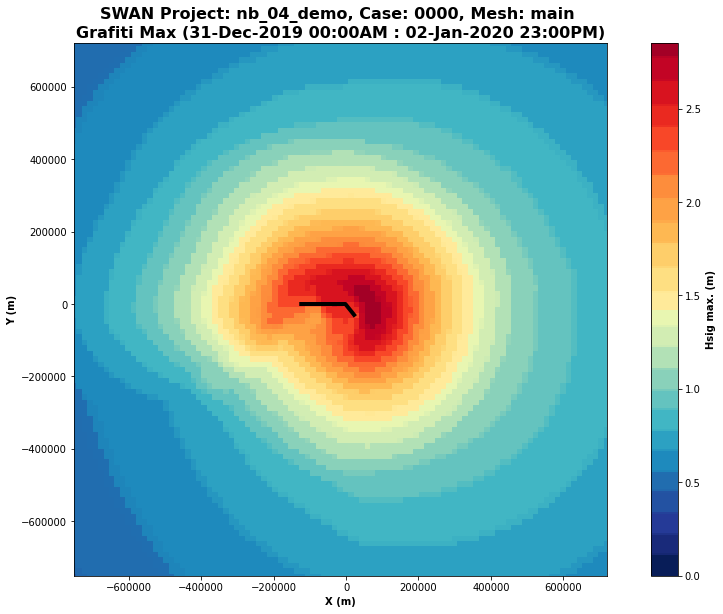

In [26]:
plot_case_output_grafiti(sw, storm_track_list = st_list, case=0);


In [27]:
#fig = plot_case_output(sw, storm_track_list = [st], t_num=300);


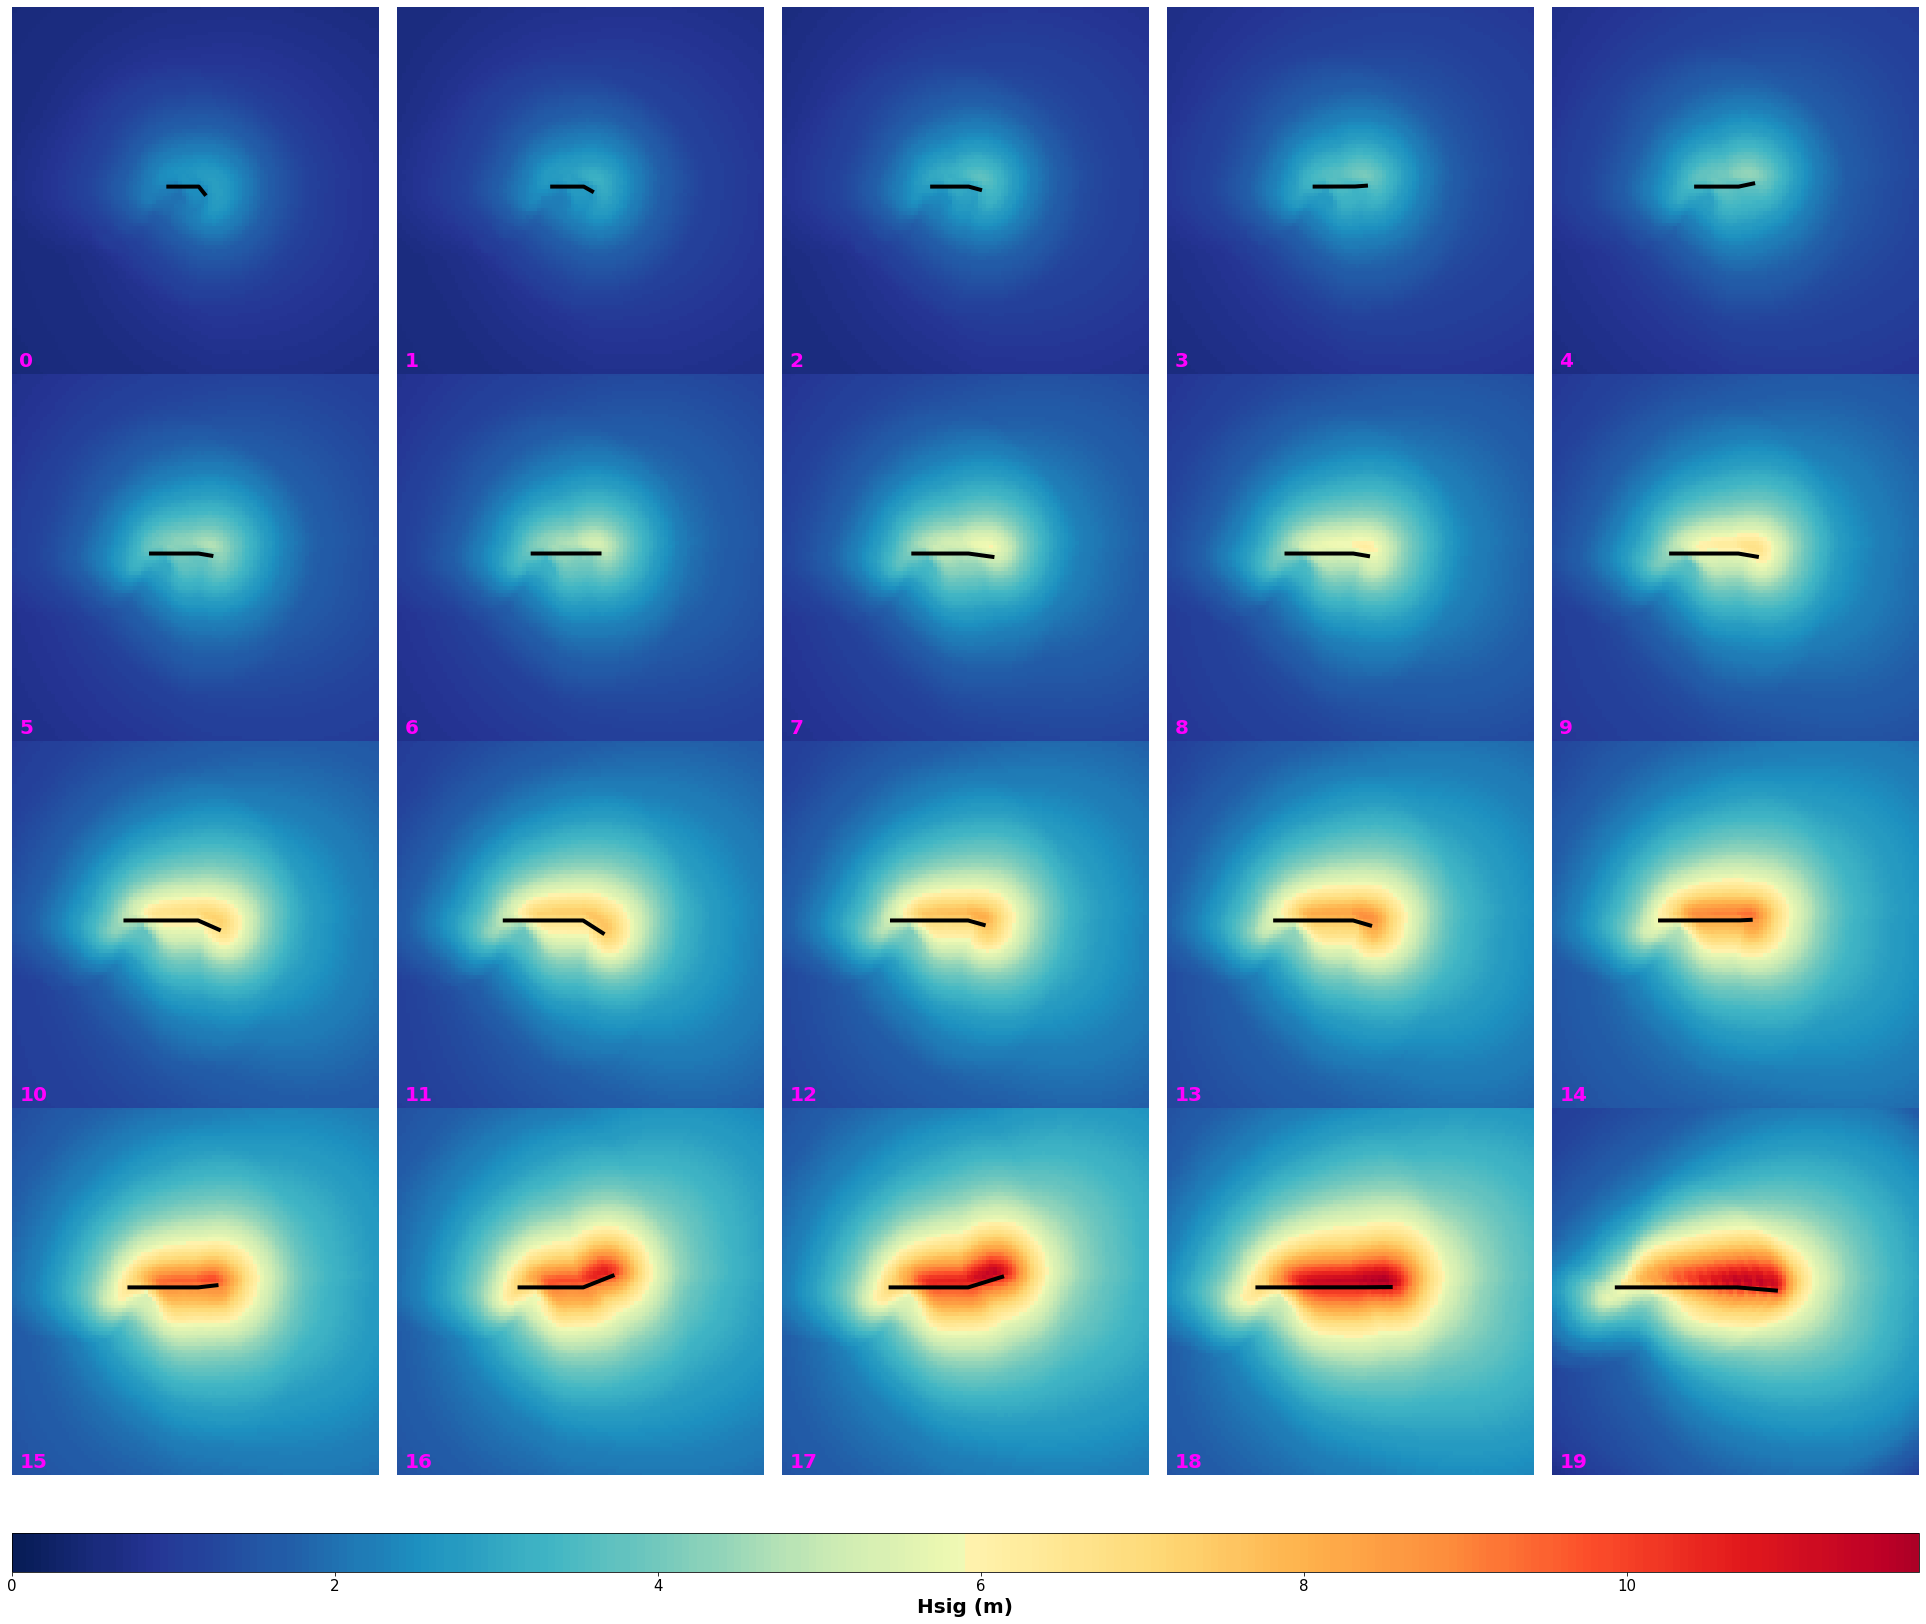

In [28]:
plot_matrix_grafiti(sw, 'Hsig', storm_track_list=st_list, case_ini=0, case_end=20, width=34.5, height=27);



#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Control Point time series

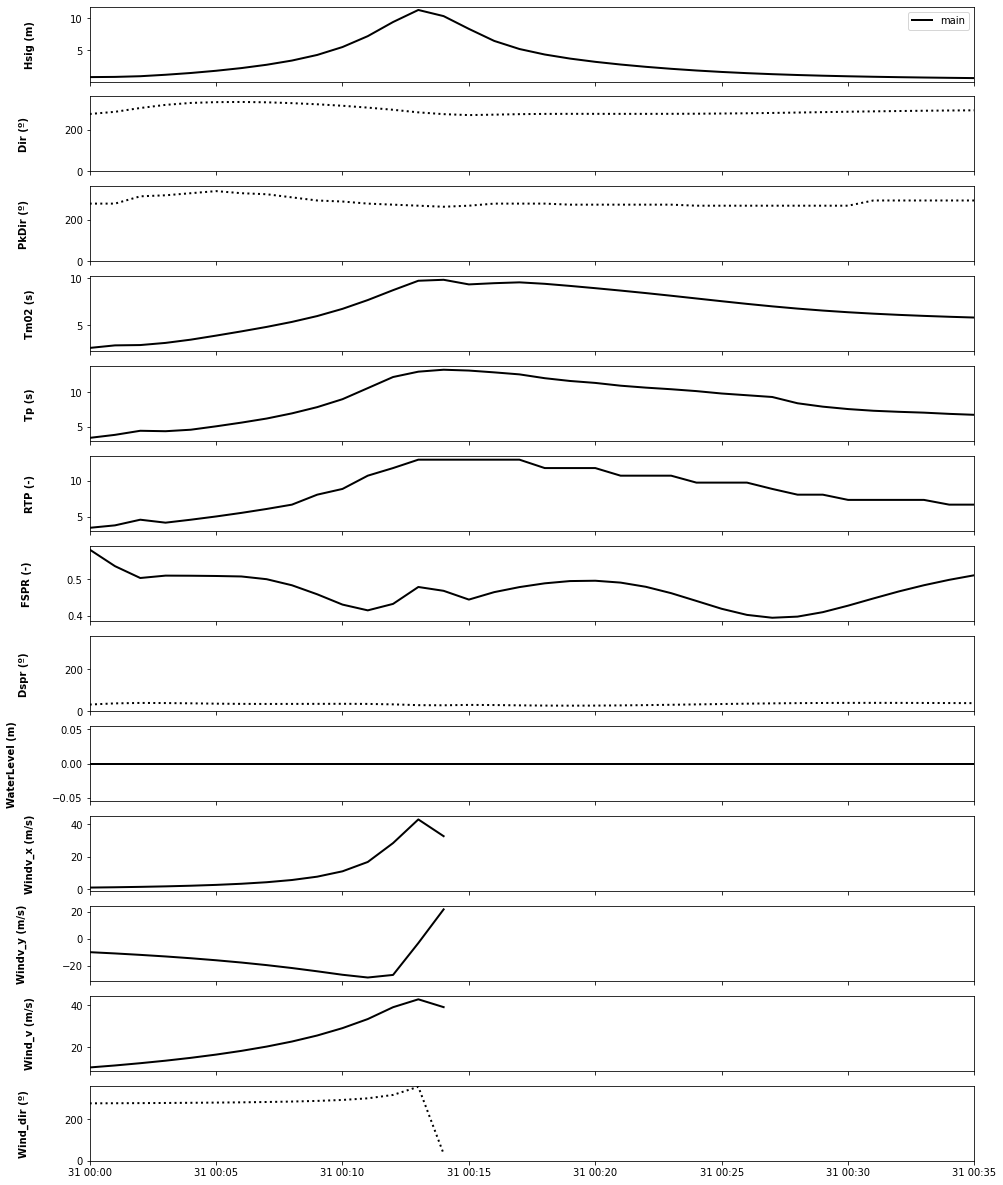

In [29]:
plot_case_output_points(sw, point=0, case=19);


###  **4.3 Extract output**

####  **Mesh main**

In [30]:
output_main = sw.extract_output(case_ini=0, case_end=1)
print(output_main[0], '\n')


<xarray.Dataset>
Dimensions:    (X: 99, Y: 99, partition: 10, time: 72)
Coordinates:
  * time       (time) datetime64[ns] 2019-12-31 ... 2020-01-02T23:00:00
  * X          (X) float64 -7.5e+05 -7.35e+05 -7.2e+05 ... 7.05e+05 7.2e+05
  * Y          (Y) float64 -7.5e+05 -7.35e+05 -7.2e+05 ... 7.05e+05 7.2e+05
Dimensions without coordinates: partition
Data variables:
    Hsig       (time, Y, X) float32 0.0 0.0 0.0 ... 0.6011535 0.5990804
    Windv_x    (time, Y, X) float32 -2.07 -2.1305103 -2.1810205 ... 0.0 0.0 0.0
    Windv_y    (time, Y, X) float32 1.72 1.7199999 1.7199999 ... 0.0 0.0 0.0
    Hs_part    (partition, time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Tp_part    (partition, time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Dir_part   (partition, time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Dspr_part  (partition, time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Wlen_part  (partition, time, Y, X) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    case 

####  **Points (mesh main)**

In [31]:
output_pts = sw.extract_output_points()
print(output_pts, '\n')


<xarray.Dataset>
Dimensions:     (case: 20, point: 6, time: 72)
Coordinates:
  * time        (time) datetime64[ns] 2019-12-31 ... 2019-12-31T01:11:00
Dimensions without coordinates: case, point
Data variables:
    Hsig        (case, point, time) float64 1.063 1.285 1.505 ... nan nan nan
    Dir         (case, point, time) float64 287.6 293.9 298.4 ... nan nan nan
    PkDir       (case, point, time) float64 287.5 307.5 307.5 ... nan nan nan
    Tm02        (case, point, time) float64 2.874 3.267 3.657 ... nan nan nan
    Tp          (case, point, time) float64 3.764 4.86 4.942 ... nan nan nan
    RTP         (case, point, time) float64 3.769 5.008 5.008 ... nan nan nan
    FSPR        (case, point, time) float64 0.5846 0.5434 0.5602 ... nan nan nan
    Dspr        (case, point, time) float64 31.55 34.96 36.6 ... nan nan nan
    DEPTH       (case, point, time) float64 1e+03 1e+03 1e+03 ... nan nan nan
    WaterLevel  (case, point, time) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Win

In [32]:
output_pts_spec = sw.extract_output_points_spec()
print(output_pts_spec, '\n')


<xarray.Dataset>
Dimensions:    (case: 20, direction: 72, frequency: 38, point: 6, time: 72)
Coordinates:
  * frequency  (frequency) float64 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * time       (time) datetime64[ns] 2019-12-31 ... 2020-01-02T23:00:00
  * direction  (direction) float64 267.5 262.5 257.5 252.5 ... -77.5 -82.5 -87.5
Dimensions without coordinates: case, point
Data variables:
    lon_pts    (case, point) float64 5e+04 1e+05 1.5e+05 ... 2e+05 2.5e+05 3e+05
    lat_pts    (case, point) float64 5e+04 1e+05 1.5e+05 ... 2e+05 2.5e+05 3e+05
    spec       (case, frequency, direction, point, time) float64 0.0 0.0 ... nan
Attributes:
    mesh_ID:  main 



In [33]:

# TODO revisado y actualizado hasta este punto. Falta postproceso para unir los vortex
import sys; sys.exit()

















SystemExit: 

###  **4.4 Analysis**

In [ ]:
from hywaves.swan.plots.common import custom_cmap, bathy_cmap


####  **Aggregate segments (POINTS)**

In [ ]:
# from 30h segments generate mask to first 6h
mask_pts = np.zeros(output_pts.Hsig.shape)
segment_overlap = 18
segment_step = 18*4   # 4*6h * 20'step
t_i = 18
for i in range(output_pts.case.size):
    if i >= 1:
        mask_pts[i,0,np.arange(t_i, t_i+segment_step)] = np.nan
        t_i += segment_overlap
        
# add mask
output_pts['mask'] = (('case','point','time'), mask_pts)


####  **Aggregate segments (OUTPUT)**

In [ ]:
# 48h+6h segments

# obtain common time index
out_concat = xr.concat(output_main[:])  # dim time not specified to align dates
out_concat


In [ ]:
# from 30h-vortex segments generate mask to first 6h-vortex
mask_out = np.zeros(out_concat.Hsig.shape)
segment_overlap = 18
segment_step = 18*4   # 4*6h * 20'step
t_i = 18
for i in range(out_concat.concat_dims.size):
    if i >= 1:
        mask_out[i,np.arange(t_i, t_i+segment_step),:,:] = np.nan
        t_i += segment_overlap
        
# add mask
out_concat['mask'] = (('concat_dims','time','lat','lon'), mask_out)


####  **Aggregate spectra (POINTS)**

In [ ]:
# from 30h segments generate mask to first 6h
mask_pts_spec = np.zeros(output_pts_spec.spec.shape)
segment_overlap = 18
segment_step = 18*4   # 4*6h * 20'step
t_i = 18
for i in range(output_pts_spec.case.size):
    if i >= 1:
        mask_pts_spec[i,:,:,:,np.arange(t_i, t_i+segment_step)] = np.nan
        t_i += segment_overlap
        
# add mask
output_pts_spec['mask'] = (('case','frequency','direction','point','time'), mask_pts_spec)


In [ ]:
output_pts_spec


####  **Store**

In [ ]:
# store
out_concat.time.attrs=[]    # error because time has no attributes
out_concat.to_netcdf((op.join(p_proj, n_proj, 'output_concat_mask.nc')))
output_pts.to_netcdf((op.join(p_proj, n_proj, 'output_pts_mask.nc')))
output_pts_spec.to_netcdf((op.join(p_proj, n_proj, 'output_pts_spec_mask.nc')))
